In [11]:
from scipy.optimize import differential_evolution
import joblib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# we use this because our model (tree) is a stepwise not a smooth cont (calculus) fxn
# grid search would be faster for two variabless but we use this for antifragility (more var)
# our opt is finding the lowest possible altitude blindfolded on a hill
# it droops paratroopers randomly and checks their altitude
# kills everyone higher and keeps only the lower
# drops next gen of paratr below or around the lowest and as such

np.random.seed(42)

Target_UCS = 150
Target_RQD = 87
Target_CAI = 3.5  # Cerchar Abrasivity Index (1-6 scale, 3.5 = medium-hard rock like granite)


NB_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NB_DIR)
model_path = os.path.join(PROJECT_ROOT, 'models')

model = joblib.load(os.path.join(model_path, 'xgb_model.pkl')) # we dont want model to be defined every time ojb fxn is called so it out

revenue_m = 5000

def calc_cost(df, rop, price):
    ROP_m_hr = rop
    Target_UCS = df['UCS_MPa']
    RQD =  df['RQD_pct'] # shap says rqd isnt as dominant factor
    current_thrust = df['Thrust_KN']
    current_rpm = df['RPM']
    current_price = price

    if ROP_m_hr < 0.1: ROP_m_hr = 0.1

    PRICE_PER_CUTTER = 4000 # $
    WEAR_FACTOR = 0.0000002  # how to calc in real data?
    #  It's an empirical fitting parameter that captures all the messy real-world details you can't easily model from first principles.
    # In a real project, you'd calibrate it from pilot bore data.




    #Energy_price = [0.15, 0.40]  # usd per KWh, grid and diesel
    #ran_price_index = np.random.randint(0,2) # upper bound is exlcusive

    Power_KW = current_thrust * current_rpm / 100

    #current_price = Energy_price[ran_price_index]

    energy_cost_m = Power_KW * current_price / ROP_m_hr


    cutter_wear_index = (Target_UCS**1.4) * Target_CAI * (current_thrust/4000) * current_rpm * WEAR_FACTOR

    cutter_cost_m = (cutter_wear_index * PRICE_PER_CUTTER) / ROP_m_hr
    Fixed_Cost_Hourly = 5000
    time_cost_m = Fixed_Cost_Hourly / ROP_m_hr
    total_cost = time_cost_m + cutter_cost_m + energy_cost_m

    return total_cost



def obj_fxn(x, current_price):

    # here x is a two element list [rpm, thrust]
    current_thrust = x[1]
    current_rpm = x[0]


    # because whichever data title was the model trained on, it should be asked in that, all input data must be there
    input_df = pd.DataFrame({ # even the order has to be same
        'UCS_MPa': [Target_UCS],
        'RQD_pct' : [Target_RQD],
        'Thrust_KN' : [current_thrust],
        'RPM' : [current_rpm]

         # since its a dataframe we need to tell it that its a row of one object


    })


    ROP_m_hr = model.predict(input_df)[0] # model.predict returns a box but we need apple within that box, we cant do
    # anything with that box, in this case its just one and its a number or else wed set up as a dataframe column
    # Physics Constraints
    if ROP_m_hr < 0.1: ROP_m_hr = 0.1

    PRICE_PER_CUTTER = 4000 # $
    WEAR_FACTOR = 0.0000002  # how to calc in real data?
    #  It's an empirical fitting parameter that captures all the messy real-world details you can't easily model from first principles.
    # In a real project, you'd calibrate it from pilot bore data.




    #Energy_price = [0.15, 0.40]  # usd per KWh, grid and diesel
    #ran_price_index = np.random.randint(0,2) # upper bound is exlcusive

    Power_KW = current_thrust * current_rpm / 100

    #current_price = Energy_price[ran_price_index]

    energy_cost_m = Power_KW * current_price / ROP_m_hr


    cutter_wear_index = (Target_UCS**1.4) * Target_CAI * (current_thrust/4000) * current_rpm * WEAR_FACTOR

    cutter_cost_m = (cutter_wear_index * PRICE_PER_CUTTER) / ROP_m_hr
    Fixed_Cost_Hourly = 5000
    time_cost_m = Fixed_Cost_Hourly / ROP_m_hr
    total_cost = time_cost_m + cutter_cost_m + energy_cost_m

    return total_cost




bounds = [(2,12), (2000,6000) ]        # bounds for rpm and thrust
# here is a critical thing, the x we specifided is this, its order wise index
# xgb can only predict within the trained data range so we used this
# even if true optimal were outside the data we could not get it
# but its good cuz its not safe to operate outside the known limits
# but if it hits the ceiling (flaltlines to 6K) thats an indication that rather thn being max limit
# we are cutting our growth due to data limitations

In [12]:

args_grid = (0.15,)
args_fuel = (0.45,)
result_fuel = differential_evolution( # here we didnt call fxn and use (), we are not calling fxn ourselves but giving
    # the optimizer the blueprint of what it should execute, x is given by bounds, thats its blakc box
    obj_fxn, # what we need to optimize
    bounds,
    args=args_fuel,
    strategy='best1bin', #"Take the Best Guy's position, add a little bit of randomness based on how far apart the other guys are, and spawn a new guy there."
    # bin = binomial crossover, we could use rand1bin, for eng control best1bin is fine
    maxiter=20, # generations of trooper landing on hills
    popsize=10, # no of paratr in a gen
    tol=0.01,
    polish=True # stop when improvement < 1%# its a randomized guess, we want it to guess in the same order for now but seed=42 is for 1.9 higher versions
)

result_grid = differential_evolution( # here we didnt call fxn and use (), we are not calling fxn ourselves but giving
    # the optimizer the blueprint of what it should execute, x is given by bounds, thats its blakc box
    obj_fxn, # what we need to optimize
    bounds,
    args=args_grid,
    strategy='best1bin', #"Take the Best Guy's position, add a little bit of randomness based on how far apart the other guys are, and spawn a new guy there."
    # bin = binomial crossover, we could use rand1bin, for eng control best1bin is fine
    maxiter=20, # generations of trooper landing on hills
    popsize=10, # no of paratr in a gen
    tol=0.01,
    polish=True # stop when improvement < 1%# its a randomized guess, we want it to guess in the same order for now but seed=42 is for 1.9 higher versions
)

--- OPTIMAL STRATEGY for GRID ---
Set RPM to:     8.19
Set Thrust to:  5530 kN
Min Cost:       $619.49 / m
--- OPTIMAL STRATEGY for FUEL---
Set RPM to:     8.38
Set Thrust to:  5260 kN
Min Cost:       $638.86 / m


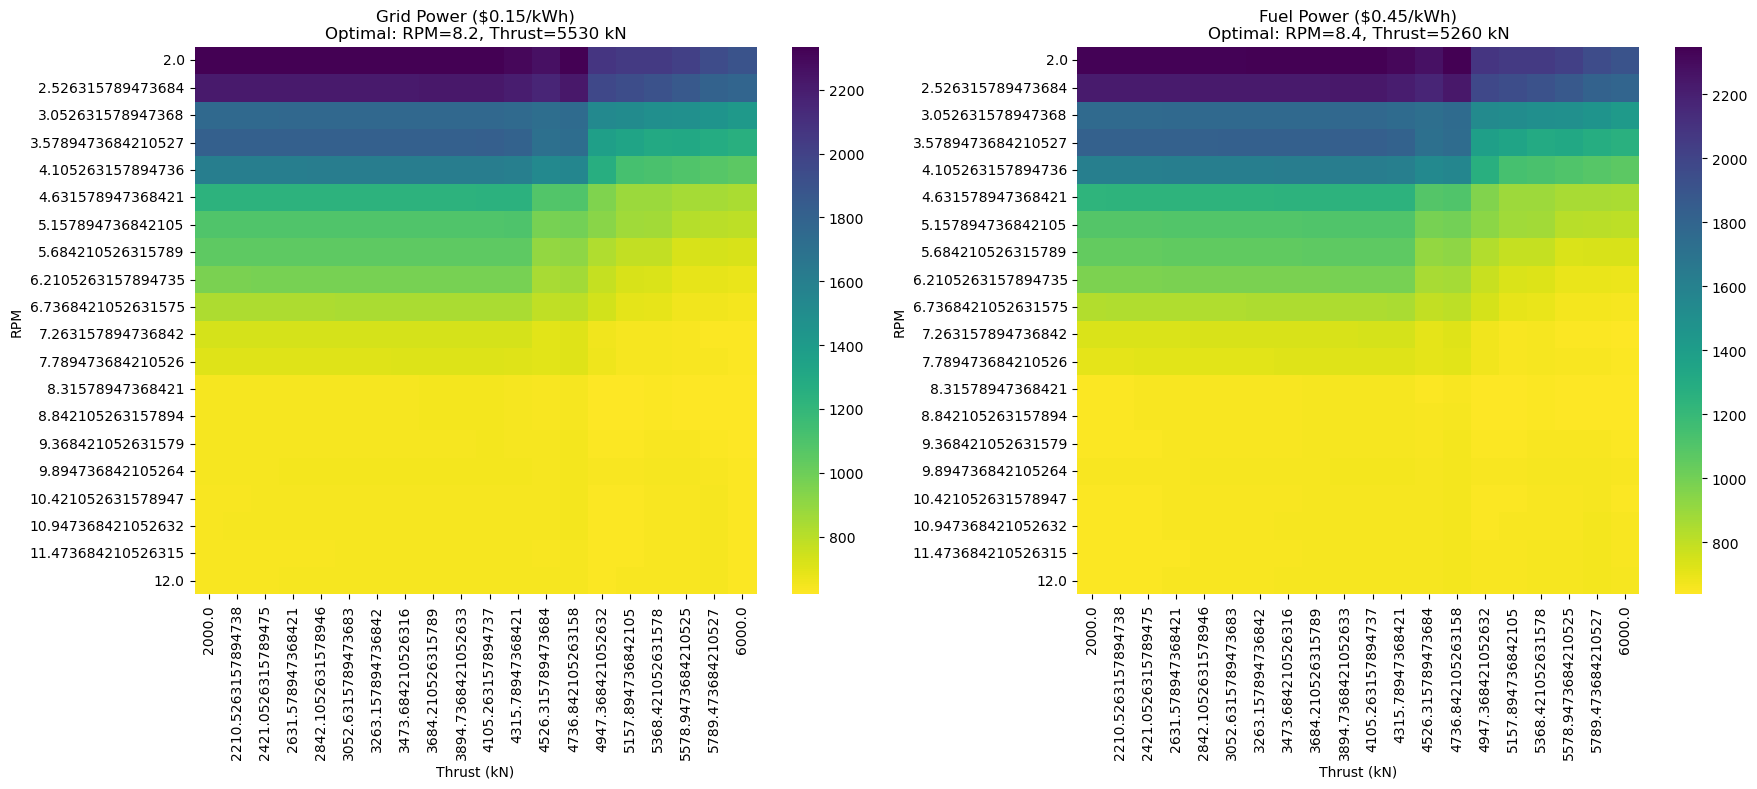

In [13]:
best_rpm_grid = result_grid.x[0]
best_thrust_grid = result_grid.x[1]
min_cost_grid = result_grid.fun

print(f"--- OPTIMAL STRATEGY for GRID ---")
print(f"Set RPM to:     {best_rpm_grid:.2f}")
print(f"Set Thrust to:  {best_thrust_grid:.0f} kN")
print(f"Min Cost:       ${min_cost_grid:.2f} / m")

best_rpm_fuel = result_fuel.x[0]
best_thrust_fuel = result_fuel.x[1]
min_cost_fuel = result_fuel.fun

print(f"--- OPTIMAL STRATEGY for FUEL---")
print(f"Set RPM to:     {best_rpm_fuel:.2f}")
print(f"Set Thrust to:  {best_thrust_fuel:.0f} kN")
print(f"Min Cost:       ${min_cost_fuel:.2f} / m")


# --- 5. THE VISUALIZATION (The Map) ---
# Since Scipy doesn't give us the map, we quickly generate a coarse grid
# just to SHOW you what the "Valley" looks like.

# Create a 20x20 grid
rpm_grid = np.linspace(2, 12, 20)
thrust_grid = np.linspace(2000, 6000, 20)

# Grid 1: For GRID pricing (0.15)
heatmap_data_grid = []
for r in rpm_grid:
    for t in thrust_grid:
        c = obj_fxn([r, t], 0.15)
        heatmap_data_grid.append({'RPM': r, 'Thrust': t, 'Cost': c})

# Grid 2: For FUEL pricing (0.45)
heatmap_data_fuel = []
for r in rpm_grid:
    for t in thrust_grid:
        c = obj_fxn([r, t], 0.45)
        heatmap_data_fuel.append({'RPM': r, 'Thrust': t, 'Cost': c})

# Create DataFrames and pivot tables
df_viz_grid = pd.DataFrame(heatmap_data_grid)
pivot_grid = df_viz_grid.pivot(index='RPM', columns='Thrust', values='Cost')

df_viz_fuel = pd.DataFrame(heatmap_data_fuel)
pivot_fuel = df_viz_fuel.pivot(index='RPM', columns='Thrust', values='Cost')

# Create two plots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Grid power
sns.heatmap(pivot_grid, cmap='viridis_r', annot=False, ax=ax1)
ax1.set_title(f"Grid Power ($0.15/kWh)\nOptimal: RPM={best_rpm_grid:.1f}, Thrust={best_thrust_grid:.0f} kN")
ax1.set_xlabel("Thrust (kN)")
ax1.set_ylabel("RPM")

# Plot 2: Fuel power
sns.heatmap(pivot_fuel, cmap='viridis_r', annot=False, ax=ax2)
ax2.set_title(f"Fuel Power ($0.45/kWh)\nOptimal: RPM={best_rpm_fuel:.1f}, Thrust={best_thrust_fuel:.0f} kN")
ax2.set_xlabel("Thrust (kN)")
ax2.set_ylabel("RPM")

plt.tight_layout()
plt.show()

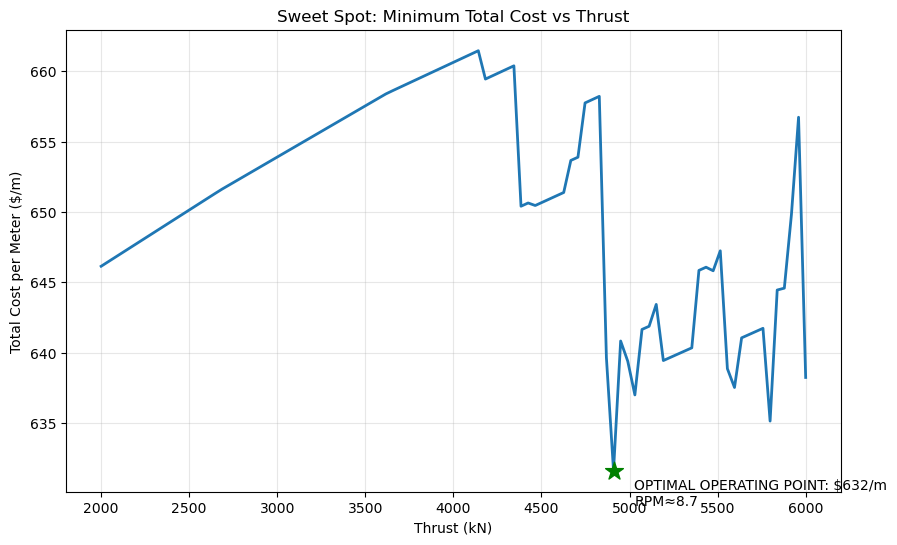

In [ ]:
import numpy as np

#price = 0.15   # grid or fuel
price = 0.45

thrust_sweep = np.linspace(2000,6000, 100)
rpm_sweep = np.linspace(2,12,10)
min_costs = []
best_rpms = []

for dumb_thrust in thrust_sweep:
    costs = [obj_fxn([rpm, dumb_thrust], price) for rpm in rpm_sweep]
    j = int(np.argmin(costs)) # we are doing indices cuz then we can straight up set up coresponding rpm as well
    min_costs.append(costs[j])
    best_rpms.append(rpm_sweep[j])

i_star = int(np.argmin(min_costs))    # global min
thrust_star = thrust_sweep[i_star]
cost_star = min_costs[i_star]
rpm_star = best_rpms[i_star]

plt.figure(figsize=(10, 6))
plt.plot(thrust_sweep, min_costs, linewidth=2)

# green star at optimum
plt.scatter([thrust_star], [cost_star], color='green', s=180, marker='*', zorder=5)
plt.annotate(
    f"OPTIMAL OPERATING POINT: ${cost_star:,.0f}/m\nRPM≈{rpm_star:.1f}",
    (thrust_star, cost_star),
    textcoords="offset points",
    xytext=(15, -25),
    ha='left'
)

plt.title("Sweet Spot: Minimum Total Cost vs Thrust")
plt.xlabel("Thrust (kN)")
plt.ylabel("Total Cost per Meter ($/m)")
plt.grid(True, alpha=0.3)
plt.show()


# we dont have equal shi because its different stuff
# xgboost does fewer calc but lands on approx
# we can fine tune increasing the max iter or pop
# the swep is a brute force im specifying 50x50, if we increase the size its take more time and obv is more accurate

In [ ]:
# constant vs variable

# for a block/zone
#rqd_fin = 75
#UCS_fin = 200
price = 0.45 # assume disel

#dumb_rpm = 10
#dumb_thrust = 5500

#X_dumb = pd.DataFrame({
 #   'UCS_MPa':[UCS_fin],
  #  'RQD_pct':[rqd_fin],
  #  'Thrust_KN': [dumb_thrust],
  # 'RPM':[dumb_rpm]
#})

#rop_dumb = model.predict(X_dumb)[0] # the value is constant FS
#cost_dumb = calc_cost(X_dumb, rop_dumb, price)

result_sov = differential_evolution( #
    obj_fxn,
    bounds,
    args=(price,), # args expect tuple
    strategy='best1bin', #"Take the Best Guy's position, add a little bit of randomness based on how far apart the other guys are, and spawn a new guy there."
    # bin = binomial crossover, we could use rand1bin, for eng control best1bin is fine
    maxiter=20, # generations of trooper landing on hills
    popsize=10, # no of paratr in a gen
    tol=0.01,
    polish=True # stop when improvement < 1%# its a randomized guess, we want it to guess in the same order for now but seed=42 is for 1.9 higher versions
)

sov_rpm = result_sov.x[0]
sov_thrust = result_sov.x[1]
sov_min_cost = result_sov.fun



print(f"--- OPTIMAL STRATEGY for FUEL---")
print(f"Set RPM to:     {sov_rpm:.2f}")
print(f"Set Thrust to:  {sov_thrust:.0f} kN")
print(f"Min Cost SOVERIGN:       ${sov_min_cost:.2f} / m")
print(f"Min Cost DUMB:       ${cost_dumb.iloc[0]:.2f} / m")

revenue = 5000



--- OPTIMAL STRATEGY for FUEL---
Set RPM to:     10.29
Set Thrust to:  4895 kN
Min Cost SOVERIGN:       $633.80 / m
Min Cost DUMB:       $739.91 / m


In [ ]:
# pd.DF can only contain key value pairs

steps_def = (np.arange(0,10,1))
field_UCS = np.random.normal(200, 20, 10)
field_UCS = field_UCS.clip(150,300)
field_RQD = np.random.normal(75, 5, 10)
field_RQD = field_RQD.clip(65, 85)

field_df = pd.DataFrame({
'steps': steps_def,
'field_UCS':field_UCS,
'field_RQD':field_RQD
}).set_index('steps')

# block for dumb
for i in range(10):
    X_dumb = pd.DataFrame({
    'UCS_MPa': field_df['field_UCS'][i],
    'RQD_pct':field_df['field_RQD'][i]
    )}

    if ucs and rqd limit:
        dumb_thrust = this
        dumb_rpm = that
    else:
        dumb_thrust = this
        dumb_rpm = that

    #or simply use lists or vectorize here idk how to do this


    X_dumb['Thrust_KN'][i] = dumb_thrust
    X_dumb['RPM'][i] = dumb_rpm # or use iloc here?


    rop_dumb = model.predict(X_dumb)[0] # the value is constant FS
    cost_dumb = calc_cost(X_dumb, rop_dumb, price)
    field_df['dumb_cost'].append(cost_dumb)

for i in range(10):
    X_sov = pd.DataFrame({
    'UCS_MPa': field_df['field_UCS'][i],
    'RQD_pct':field_df['field_RQD'][i]
    )}

    if ucs and rqd limit:
        sov_thrust = this
        sov_rpm = that
    else:
        sov_thrust = this
        sov_rpm = that

    #or simply use lists or vectorize here idk how to do this


    X_sov['Thrust_KN'][i] = sov_thrust
    X_sov['RPM'][i]= sov_rpm # or use iloc here?


    rop_dumb = model.predict(X_sov)[0] # the value is constant FS
    cost_dumb = calc_cost(X_sov, rop_dumb, price)
    field_df['dumb_cost'].append(cost_dumb)



